### Data Skipping and Z-Ordering
 With the release of Data Skipping in Delta Lake 1.2.0, column-level statistics like min/max are now available. Statistics are saved in the Delta Lake transaction log (DeltaLog) every time an `add` action is performed corresponding to adding a new Parquet file.
 By leveraging min-max ranges, Delta Lake is able to skip the Parquet files that are out of the range of the querying field values (Data Skipping). In order to make it effective, data can be clustered by Z-Order columns so that min-max ranges are narrow and, ideally, non-overlapping.

### Delta Table Structure

 You are wroking at a cyber security company. Your team collects traffic data which is created by an open source
network traffic analyzer. The schema is straightforward:

In [64]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip


builder = SparkSession.builder.appName('CreateDeltaTables') \
    .config(
        'spark.jars.packages',
        'io.delta:delta-core_2.12:2.2.0') \
    .config(
        'spark.sql.extensions',
        'io.delta.sql.DeltaSparkSessionExtension') \
    .config(
        'spark.sql.catalog.spark_catalog',
        'org.apache.spark.sql.delta.catalog.DeltaCatalog')

spark = configure_spark_with_delta_pip(builder).getOrCreate()

security = spark.read \
    .format('csv') \
    .option('header', 'true') \
    .option('inferSchema', 'true') \
    .load('../../data/security.csv')
security.show(n=5, truncate=False)

+--------------+--------+---------------+--------+
|src_ip        |src_port|dst_ip         |dst_port|
+--------------+--------+---------------+--------+
|236.71.116.143|32494   |245.119.140.199|12338   |
|218.85.253.101|49762   |49.104.143.5   |18315   |
|248.103.35.69 |48259   |216.87.133.237 |12454   |
|163.88.107.182|46859   |100.82.126.51  |62569   |
|145.139.254.71|17573   |245.142.160.215|15920   |
+--------------+--------+---------------+--------+
only showing top 5 rows



The structure of the table is as follows:

In [2]:
%%bash

tree -a ../../data/security-table

../../data/security-table
├── .part-00000-0825fe82-4459-49fb-b69b-4ded01674f63-c000.snappy.parquet.crc
├── .part-00000-2c886aa1-d13a-4f54-8bd4-0ac291ab5e9a-c000.snappy.parquet.crc
├── .part-00000-4aa0ba55-e6da-47d5-b256-dcdd2cbcd534-c000.snappy.parquet.crc
├── .part-00000-65d0b700-60cf-403c-b69f-20a654d1f74f-c000.snappy.parquet.crc
├── .part-00000-9e9fc6eb-a907-43db-8eda-d7ca94f825b8-c000.snappy.parquet.crc
├── .part-00000-a5c1f6e4-3317-4a57-8287-af4b12f5e060-c000.snappy.parquet.crc
├── .part-00000-ae3df0d8-d90d-44af-8f26-7a4f209d5df9-c000.snappy.parquet.crc
├── .part-00000-bc507886-54ca-4e60-b0ac-6ef0103fee94-c000.snappy.parquet.crc
├── .part-00000-c71f7f2e-05df-4386-a30a-9a154e2d6005-c000.snappy.parquet.crc
├── .part-00000-eb12aca8-4707-4b2f-bfdd-1e36d3d7d324-c000.snappy.parquet.crc
├── _delta_log
│   ├── .00000000000000000000.json.crc
│   ├── .00000000000000000001.json.crc
│   ├── .00000000000000000002.json.crc
│   ├── .00000000000000000003.json.crc
│   ├── .00000000000000000004.jso

### Filter Clauses

 Suppose we are only interested in the traffic which satisfies the following conditions:

 - condition 1: 128.0.0.0 <= `src_ip` <= 191.255.255.255
 - condition 2: 1024 <= `src_port` <= 65535
 - condition 3: 128.0.0.0 <= `dst_ip` <= 191.255.255.255 and 1024 <= `dst_port` <= 65535

### Evaluation

 Let us define Skipping Effecticeness as follows:

`Skipping Effectiveness := # of filtered Parquet files / total # of Parquet files`

### Skipping Effectiveness

 Now, let's inspect the skipping effectiveness. Your end goal is likely to minimize the total amount of time spent on running these queries and the egress cost, but, for illustration purposes, let’s instead define our cost function as the total number of records scanned:

In [62]:
from deltalake import DeltaTable
import pyarrow.dataset as ds
import pandas as pd
import json


def overlap(a, b):
    return a[0] <= b[0] <= a[1] or b[0] <= a[0] <= b[1]

dt = DeltaTable('../../data/security-table')

lhs = dt.get_add_actions().to_pandas()[['min']].values.tolist()
lhs = [x for r in lhs for x in r]
lhs = pd.DataFrame.from_dict(lhs)

rhs = dt.get_add_actions().to_pandas()[['max']].values.tolist()
rhs = [x for r in rhs for x in r]
rhs = pd.DataFrame.from_dict(rhs)

clause_1, clause_2, clause_3 = 0, 0, 0
for (_, min), (_, max) in zip(lhs.iterrows(), rhs.iterrows()):
    if overlap(('128.0.0.0', '191.255.255.255'), (min['src_ip'], max['src_ip'])):
        clause_1 += 1
    if overlap((1024, 65535), (min['src_port'], max['src_port'])):
        clause_2 += 1
    if overlap(('128.0.0.0', '191.255.255.255'), (min['dst_ip'], max['dst_ip'])) and \
    overlap((1024, 65535), (min['dst_port'], max['dst_port'])):
        clause_3 += 1
print('128.0.0.0 <= src_ip <= 191.255.255.255: ', 1 - clause_1 / 10)
print('1024 <= src_port <= 65535: ', 1 - clause_2 / 10)
print('128.0.0.0 <= dst_ip <= 191.255.255.255 and 1024 <= dst_port <= 65535: ', 1 - clause_3 / 10)

128.0.0.0 <= src_ip <= 191.255.255.255:  0.0
1024 <= src_port <= 65535:  0.0
128.0.0.0 <= dst_ip <= 191.255.255.255 and 1024 <= dst_port <= 65535:  0.0


(0.0, 1.0)

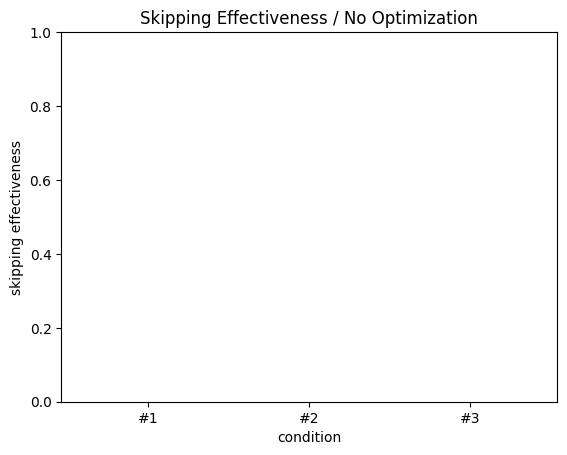

In [6]:
import matplotlib.pyplot as plt
import numpy as np

left = np.array([1, 2, 3])
height = np.array([0.0, 0.0, 0.0])
label = ['#1', '#2', '#3']

plt.bar(left, height, tick_label=label, align='center')
plt.title('Skipping Effectiveness / No Optimization')
plt.xlabel('condition')
plt.ylabel('skipping effectiveness')
plt.ylim([0.0, 1.0])

### Partition by Range (Explicit Sorting)
 
 As our data is randomly generated and so there are no correlations. So let’s try explicitly sorting data before writing it.

In [3]:
df = spark.read \
    .format('delta') \
    .load('../../data/security-table')
df.repartitionByRange(10, 'src_ip', 'src_port', 'dst_ip') \
    .write \
    .mode('overwrite') \
    .format('delta') \
    .save('../../data/security-table')

23/04/29 02:12:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


The structure of the table is as follows:

In [4]:
%%bash

tree -a ../../data/security-table-part-by-range

../../data/security-table-part-by-range
├── .part-00000-a3ad6739-b667-46fa-a258-80dacf2be068-c000.snappy.parquet.crc
├── .part-00001-bd90d54e-0665-46b8-887c-6917bd3ad0bf-c000.snappy.parquet.crc
├── .part-00002-a9cf4f02-717d-4670-8931-a7ca0ea8b87d-c000.snappy.parquet.crc
├── .part-00003-e0d7e3f9-06e5-472f-a6e0-3fd6baf32ac8-c000.snappy.parquet.crc
├── .part-00004-4e8c4634-1c64-4ca8-903e-e39fb64fe825-c000.snappy.parquet.crc
├── .part-00005-35e20c62-8b06-49c9-be6a-55fb5f1b44fc-c000.snappy.parquet.crc
├── .part-00006-69d993dc-09e0-4bf9-bab2-a1498d16da2a-c000.snappy.parquet.crc
├── .part-00007-2174b183-5460-4b35-8704-681d792ec3cc-c000.snappy.parquet.crc
├── .part-00008-79672ece-f515-4d5e-a5c2-4ab9d6a50dc1-c000.snappy.parquet.crc
├── .part-00009-d362af9e-5ff8-458f-819c-d2e8e1d90687-c000.snappy.parquet.crc
├── _delta_log
│   ├── .00000000000000000000.json.crc
│   └── 00000000000000000000.json
├── part-00000-a3ad6739-b667-46fa-a258-80dacf2be068-c000.snappy.parquet
├── part-00001-bd90d54e-0665-4

### Skipping Effectiveness

 Now, let's inspect the skipping effectiveness. Your end goal is likely to minimize the total amount of time spent on running these queries and the egress cost, but, for illustration purposes, let’s instead define our cost function as the total number of records scanned:

In [63]:
from deltalake import DeltaTable
import pyarrow.dataset as ds
import pandas as pd
import json


def overlap(a, b):
    return a[0] <= b[0] <= a[1] or b[0] <= a[0] <= b[1]

dt = DeltaTable('../../data/security-table-part-by-range')

lhs = dt.get_add_actions().to_pandas()[['min']].values.tolist()
lhs = [x for r in lhs for x in r]
lhs = pd.DataFrame.from_dict(lhs)

rhs = dt.get_add_actions().to_pandas()[['max']].values.tolist()
rhs = [x for r in rhs for x in r]
rhs = pd.DataFrame.from_dict(rhs)

clause_1, clause_2, clause_3 = 0, 0, 0
for (_, min), (_, max) in zip(lhs.iterrows(), rhs.iterrows()):
    if overlap(('128.0.0.0', '191.255.255.255'), (min['src_ip'], max['src_ip'])):
        clause_1 += 1
    if overlap((1024, 65535), (min['src_port'], max['src_port'])):
        clause_2 += 1
    if overlap(('128.0.0.0', '191.255.255.255'), (min['dst_ip'], max['dst_ip'])) and \
    overlap((1024, 65535), (min['dst_port'], max['dst_port'])):
        clause_3 += 1
print('128.0.0.0 <= src_ip <= 191.255.255.255: ', 1 - clause_1 / 10)
print('1024 <= src_port <= 65535: ', 1 - clause_2 / 10)
print('128.0.0.0 <= dst_ip <= 191.255.255.255 and 1024 <= dst_port <= 65535: ', 1 - clause_3 / 10)

128.0.0.0 <= src_ip <= 191.255.255.255:  0.6
1024 <= src_port <= 65535:  0.0
128.0.0.0 <= dst_ip <= 191.255.255.255 and 1024 <= dst_port <= 65535:  0.0


(0.0, 1.0)

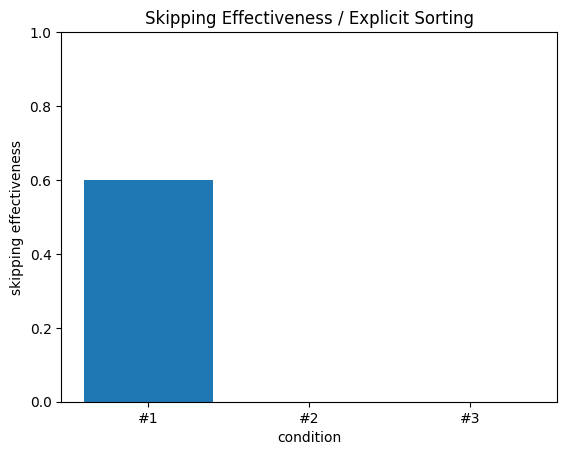

In [10]:
import matplotlib.pyplot as plt
import numpy as np

left = np.array([1, 2, 3])
height = np.array([0.6, 0.0, 0.0])
label = ['#1', '#2', '#3']

plt.bar(left, height, tick_label=label, align='center')
plt.title('Skipping Effectiveness / Explicit Sorting')
plt.xlabel('condition')
plt.ylabel('skipping effectiveness')
plt.ylim([0.0, 1.0])

### Z-Order Clustering
 
 Z-ordering is a technique to colocate related information in the same set of files. This optimization dramatically reduces the amount of data that Delta Table needs to read. 

In [65]:
import delta

deltaTable = delta.DeltaTable.forPath(spark, '../../data/security-table')
spark.conf.set('spark.databricks.delta.optimize.maxFileSize', 1024*50)
deltaTable.optimize().executeZOrderBy('src_ip', 'src_port', 'dst_ip', 'dst_port')

DataFrame[path: string, metrics: struct<numFilesAdded:bigint,numFilesRemoved:bigint,filesAdded:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,filesRemoved:struct<min:bigint,max:bigint,avg:double,totalFiles:bigint,totalSize:bigint>,partitionsOptimized:bigint,zOrderStats:struct<strategyName:string,inputCubeFiles:struct<num:bigint,size:bigint>,inputOtherFiles:struct<num:bigint,size:bigint>,inputNumCubes:bigint,mergedFiles:struct<num:bigint,size:bigint>,numOutputCubes:bigint,mergedNumCubes:bigint>,numBatches:bigint,totalConsideredFiles:bigint,totalFilesSkipped:bigint,preserveInsertionOrder:boolean,numFilesSkippedToReduceWriteAmplification:bigint,numBytesSkippedToReduceWriteAmplification:bigint,startTimeMs:bigint,endTimeMs:bigint,totalClusterParallelism:bigint,totalScheduledTasks:bigint,autoCompactParallelismStats:struct<maxClusterActiveParallelism:bigint,minClusterActiveParallelism:bigint,maxSessionActiveParallelism:bigint,minSessionActiveParallelism:bigint>>]

The structure of the table is as follows:

In [66]:
%%bash

tree -a ../../data/security-table

../../data/security-table
├── .part-00000-0825fe82-4459-49fb-b69b-4ded01674f63-c000.snappy.parquet.crc
├── .part-00000-2c886aa1-d13a-4f54-8bd4-0ac291ab5e9a-c000.snappy.parquet.crc
├── .part-00000-4aa0ba55-e6da-47d5-b256-dcdd2cbcd534-c000.snappy.parquet.crc
├── .part-00000-65d0b700-60cf-403c-b69f-20a654d1f74f-c000.snappy.parquet.crc
├── .part-00000-8aa886df-d7bf-44ca-8e3d-91e601cdfe51-c000.snappy.parquet.crc
├── .part-00000-9e9fc6eb-a907-43db-8eda-d7ca94f825b8-c000.snappy.parquet.crc
├── .part-00000-a5c1f6e4-3317-4a57-8287-af4b12f5e060-c000.snappy.parquet.crc
├── .part-00000-ae3df0d8-d90d-44af-8f26-7a4f209d5df9-c000.snappy.parquet.crc
├── .part-00000-bc507886-54ca-4e60-b0ac-6ef0103fee94-c000.snappy.parquet.crc
├── .part-00000-c71f7f2e-05df-4386-a30a-9a154e2d6005-c000.snappy.parquet.crc
├── .part-00000-eb12aca8-4707-4b2f-bfdd-1e36d3d7d324-c000.snappy.parquet.crc
├── .part-00001-fe1754b2-86a1-4f5f-be3a-5fc62eb2933c-c000.snappy.parquet.crc
├── .part-00002-1c839f6e-77ae-4ecc-844c-203b948818

In [67]:
from deltalake import DeltaTable
import pyarrow.dataset as ds
import pandas as pd
import json


def overlap(a, b):
    return a[0] <= b[0] <= a[1] or b[0] <= a[0] <= b[1]

dt = DeltaTable('../../data/security-table')

lhs = dt.get_add_actions().to_pandas()[['min']].values.tolist()
lhs = [x for r in lhs for x in r]
lhs = pd.DataFrame.from_dict(lhs)

rhs = dt.get_add_actions().to_pandas()[['max']].values.tolist()
rhs = [x for r in rhs for x in r]
rhs = pd.DataFrame.from_dict(rhs)

clause_1, clause_2, clause_3 = 0, 0, 0
for (_, min), (_, max) in zip(lhs.iterrows(), rhs.iterrows()):
    if overlap(('128.0.0.0', '191.255.255.255'), (min['src_ip'], max['src_ip'])):
        clause_1 += 1
    if overlap((1024, 65535), (min['src_port'], max['src_port'])):
        clause_2 += 1
    if overlap(('128.0.0.0', '191.255.255.255'), (min['dst_ip'], max['dst_ip'])) and \
    overlap((1024, 65535), (min['dst_port'], max['dst_port'])):
        clause_3 += 1
print('128.0.0.0 <= src_ip <= 191.255.255.255: ', 1 - clause_1 / 10)
print('1024 <= src_port <= 65535: ', 1 - clause_2 / 10)
print('128.0.0.0 <= dst_ip <= 191.255.255.255 and 1024 <= dst_port <= 65535: ', 1 - clause_3 / 10)

128.0.0.0 <= src_ip <= 191.255.255.255:  0.6
1024 <= src_port <= 65535:  0.4
128.0.0.0 <= dst_ip <= 191.255.255.255 and 1024 <= dst_port <= 65535:  0.4


(0.0, 1.0)

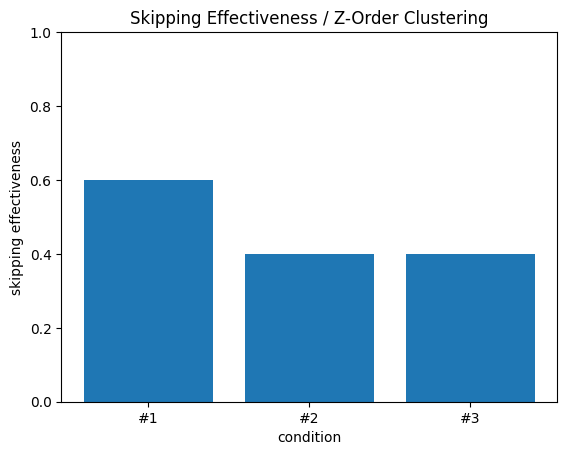

In [25]:
import matplotlib.pyplot as plt
import numpy as np

left = np.array([1, 2, 3])
height = np.array([0.6, 0.4, 0.4])
label = ['#1', '#2', '#3']

plt.bar(left, height, tick_label=label, align='center')
plt.title('Skipping Effectiveness / Z-Order Clustering')
plt.xlabel('condition')
plt.ylabel('skipping effectiveness')
plt.ylim([0.0, 1.0])

(0.0, 1.0)

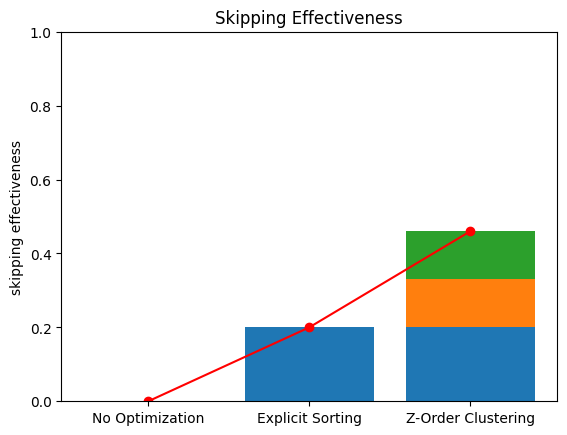

In [24]:
import matplotlib.pyplot as plt
import numpy as np

left = np.array([1, 2, 3])
height1 = np.array([0.0, 0.2, 0.2])
height2 = np.array([0.0, 0.0, 0.13])
height3 = np.array([0.0, 0.0, 0.13])
label = ['No Optimization', 'Explicit Sorting', 'Z-Order Clustering']

plt.bar(left, height1, tick_label=label, align="center")
plt.bar(left, height2, bottom=height1)
plt.bar(left, height3, bottom=height1 + height2)
plt.plot(left, [0.0, 0.2, 0.46], color='red')
plt.scatter(left, [0.0, 0.2, 0.46], color='red')
plt.title("Skipping Effectiveness")
plt.ylabel("skipping effectiveness")
plt.ylim([0.0, 1.0])